In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys
sys.path.append('../..')
import pandas as pd
from model import VAE
import Model.input_pipeline
from Model.results import get_df, get_stats, final_plot
from joblib import load

2024-04-16 12:21:54.595831: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-16 12:21:54.927837: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 12:21:54.927894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 12:21:54.949504: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-16 12:21:55.017967: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-16 12:21:55.021677: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Helper functions

In [2]:
def sample_normal(num_examples_to_generate, model):
    latent_dim = model.latent_dim
    random_mean = tf.random.normal(mean = 0, stddev=1 ,
        shape=[num_examples_to_generate, latent_dim])
    log_var = tf.random.normal(mean = 0, stddev=1,
        shape=[num_examples_to_generate, latent_dim])
    z = model.reparameterize(random_mean, log_var)
    predictions = model.sample(z)
    return predictions
    
def plus_encode_data(data):
    data = tf.reshape(data, shape=(data.shape[0], -1))
    mean_data = tf.reduce_mean(data, axis=1, keepdims=True)
    need_change = tf.cast(mean_data < 0.5, data.dtype)
    data = data * (1 - 2 * need_change) + need_change
    data = tf.reshape(data, shape=(-1, 32, 32, 1))
    return data   
    
def random_swap(data):
    data = tf.reshape(data, shape = (data.shape[0], -1))
    swap_mask = 2 * (np.random.random(size = (data.shape[0], 1)) > 0.5) - 1
    data = tf.multiply(data, swap_mask)
    data = tf.reshape(data, shape = (-1, 32, 32, 1))
    return data
    
def sample(num_examples_to_generate, vae, gm_mean, gm_var):
    random_mean, _ = gm_mean.sample(num_examples_to_generate)
    log_var, _ = gm_var.sample(num_examples_to_generate)
    random_mean = tf.cast(random_mean, tf.float32)
    log_var = tf.cast(log_var, tf.float32)
    z = vae.reparameterize(random_mean, log_var)
    predictions = vae.sample(z)
    return predictions

def load_model_at_T(t, latent_dim = 200):
    model = VAE(latent_dim)
    dummy_input = tf.zeros((1, 32, 32, 1))
    model(dummy_input)
    model.load_weights(f'Results/22-03-2024/{t:.2}/vae{t:.2}.h5')
    #gm_mean = load(f'models/22-03-2024/{t:.2}/gm_means.pkl')
    #gm_var = load(f'models/22-03-2024/{t:.2}/gm_vars.pkl')
    return model #gm_mean, gm_var

## Models dictionary

In [8]:
temps = np.arange(2.0, 3.05, 0.1)
titles = [f"Temperature: {t:.2}" for t in temps]
models = {t: load_model_at_T(t) for t in temps}

# Compare with monte carlo

## Mean Var expermients

In [31]:
temp = 3.0
model = load_model_at_T(temp)
batch_size = 5000

trainset_path = f"../../GetData/Python/Data/Data{temp:.2}.tfrecord"
train_set = input_pipeline.dataset_tfrecord_pipeline(trainset_path, flatten=False, batch_size=batch_size)

testset_path = f"../../GetData/Python/Data/TestData{temp:.2}.tfrecord"
test_set = input_pipeline.dataset_tfrecord_pipeline(testset_path, flatten=False, batch_size=batch_size)

# data mc trainset
data_mc = next(iter(train_set))
data_plus = plus_encode_data(data_mc)
encoded = model.encode(data_plus)
data_mc = 2 * data_mc - 1
df_monte_carlo = get_df(data_mc)

# logvar, mean
means, vars =  encoded
means = means.numpy()
vars = vars.numpy()

# data testset encoded
data_test = next(iter(test_set))
test_reconstructed = model(data_test)
test_sample = 2 * np.random.binomial(1, test_reconstructed) - 1
df_test = get_df(test_sample)

# empirical logvar and mean
sample_data_std = sample_new(batch_size, model, means, vars)
sample_data_std = 2 * np.random.binomial(1, sample_data_std) - 1
spin_sample = random_swap(spin_sample)
df_sampled_std = get_df(sample_data_std)

# normal logvar and mean
sample_data = sample(batch_size, model)
spin_sample = 2 * np.random.binomial(1, sample_data) - 1
spin_sample = random_swap(spin_sample)
df_sampled = get_df(spin_sample)

In [32]:
df_sampled['Type'] = 'Sampled from N(0,1)'
df_monte_carlo['Type'] = 'Monte Carlo'
df_test['Type'] = 'Testset decoded'
df_sampled_std['Type'] = 'Sampled from empirical '
df = pd.concat([df_sampled, df_monte_carlo, df_test, df_sampled_std])

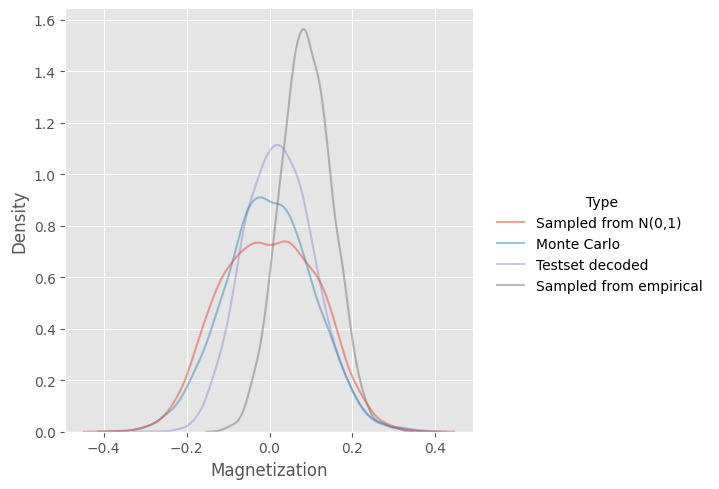

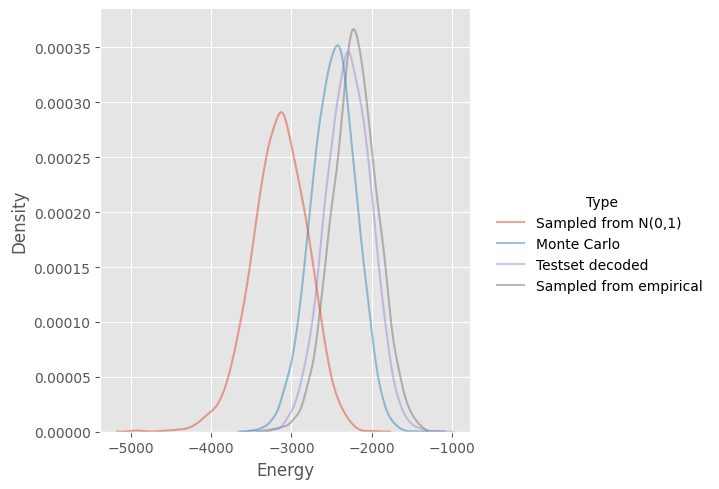

In [33]:
import seaborn as sns

sns.displot(data=df, x='Magnetization', kind='kde', hue = 'Type', alpha=0.5)
plt.savefig("Magnetization.png")
sns.displot(data=df, x='Energy', kind='kde', hue = 'Type', alpha=0.5)
plt.savefig("Energy.png")

## Kolmogorov-Smirnov test

In [34]:
from scipy import stats

def ks_test(data, means = None, variances = None):
    if means is None:
        means = np.mean(data, axis=0)
    if variances is None:
        variances = np.var(data, axis=0)
    ks_results = [stats.kstest(data[:, i], 'norm', args=(means[i], np.sqrt(variances[i]))).pvalue for i in range(data.shape[1])]
    return ks_results

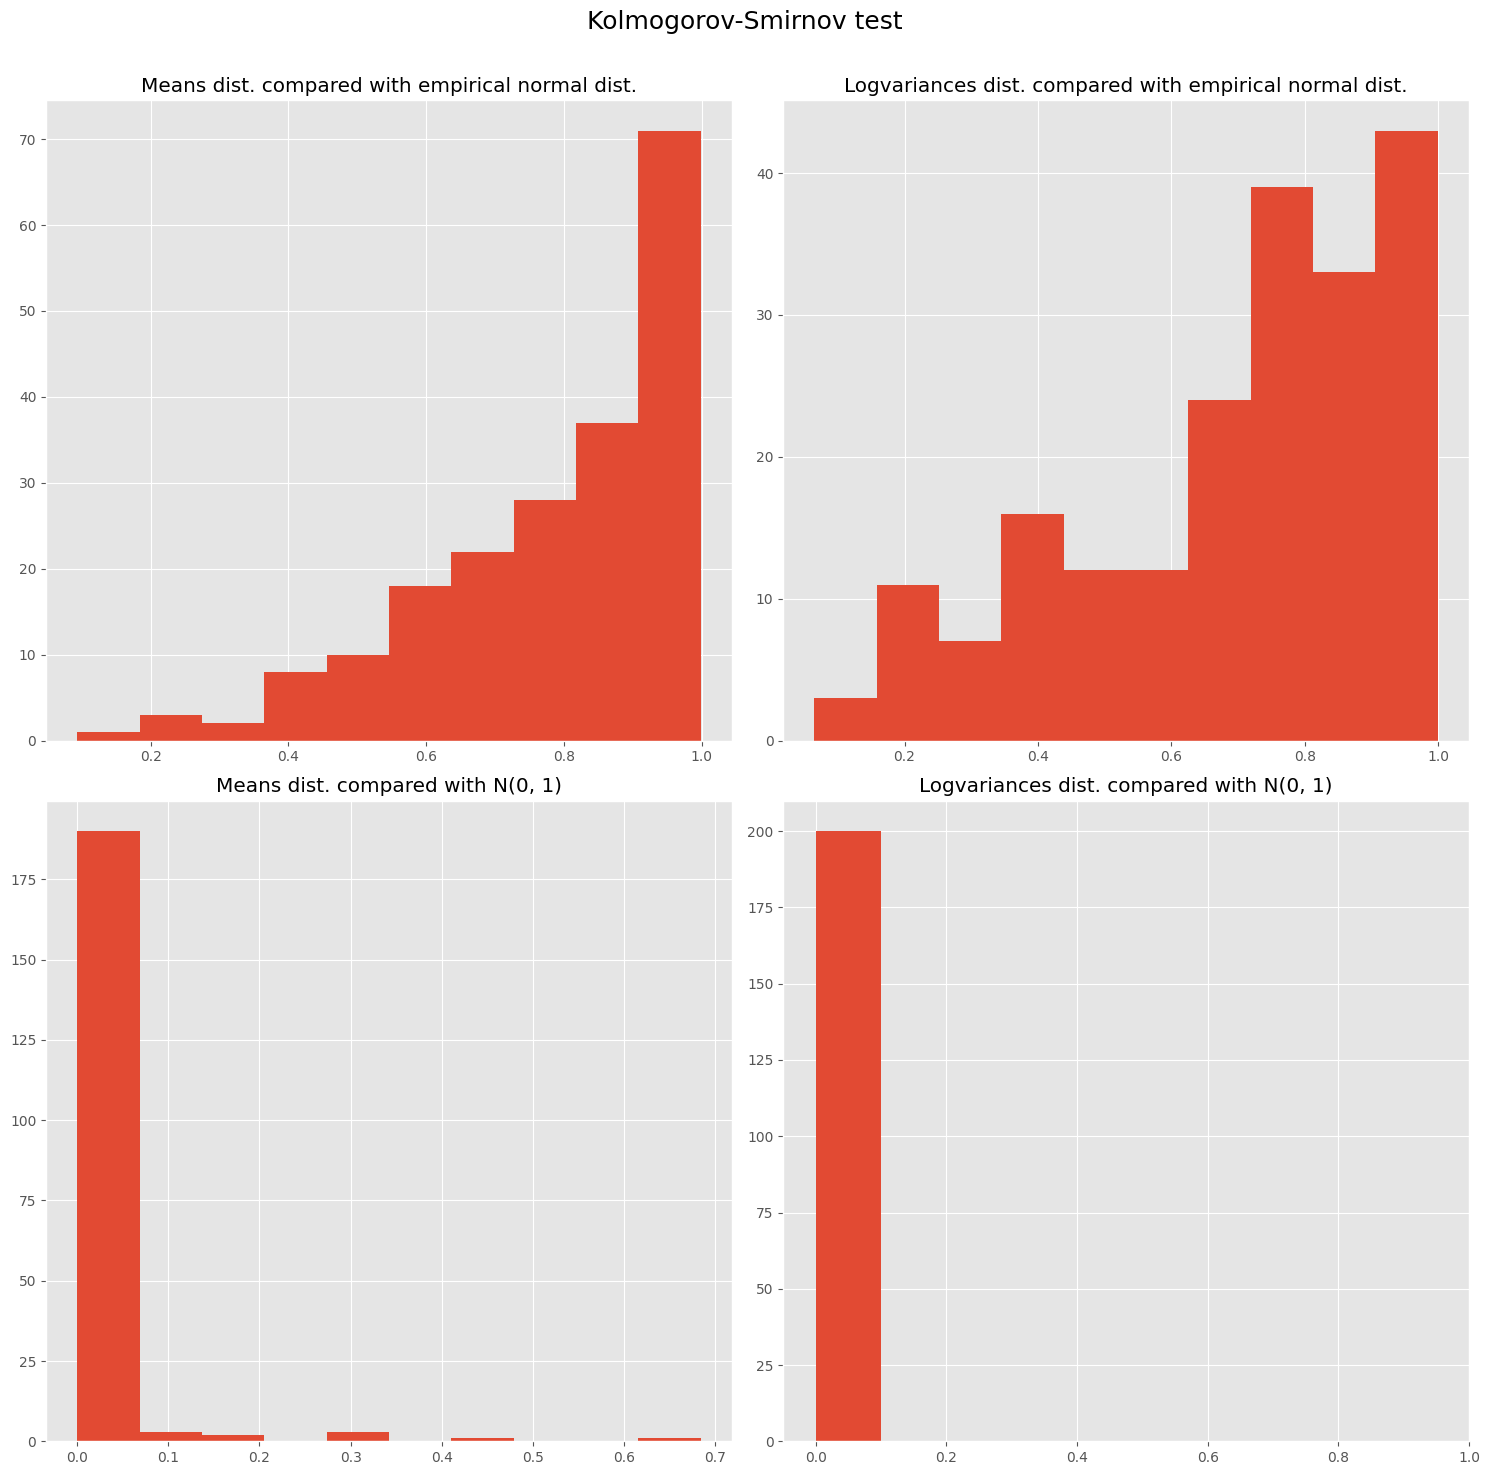

In [35]:
import matplotlib.pyplot as plt

# Assuming ks_means and ks_variances are your data
ks_means = ks_test(means)
ks_variances = ks_test( vars)

# Assuming ks_means and ks_variances are your data
ks_means_standard = ks_test(means, np.zeros(shape=200), np.ones(shape=200))
ks_variances_standard = ks_test(vars, np.zeros(shape=200), np.ones(shape=200))

# Set the style
plt.style.use('ggplot')

# Create a figure and a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Plot the histograms on the subplots
axs[0][0].hist(ks_means)
axs[0][0].set_title('Means dist. compared with empirical normal dist.')

axs[0][1].hist(ks_variances)
axs[0][1].set_title('Logvariances dist. compared with empirical normal dist.')

# Plot the histograms on the subplots
axs[1][0].hist(ks_means_standard, bins=10)
axs[1][0].set_title('Means dist. compared with N(0, 1)')

axs[1][1].hist(ks_variances_standard, bins=10)
axs[1][1].set_title('Logvariances dist. compared with N(0, 1)')
axs[1][1].set_xlim(-.05,1)

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Adjust the top padding to make room for the suptitle

# Display the figure with its subplots
plt.savefig("ks_test.png")
plt.show()


# Data

In [4]:
data_list = []
for temp in temps:

    trainset_path = f"../../GetData/Python/Data/Data{temp:.2}.tfrecord"
    batch_size = 100
    train_set = Model.input_pipeline.dataset_tfrecord_pipeline(trainset_path, flatten=False, batch_size=batch_size)
    
    vae = models[temp]
    data_mc = []
    sample_data = []

    for data in train_set:
        data_mc.append(data)
        sample_data.append(sample_normal(batch_size, vae))
    
    data_mc = np.concatenate(data_mc)
    sample_data = np.concatenate(sample_data)

    data_mc = 2 * data_mc - 1
    spin_sample = 2 * np.random.binomial(1, sample_data) - 1


    # Monte Carlo
    df_monte_carlo = get_df(data_mc)
    mc_stats = get_stats(df_monte_carlo, temp)
    mc_stats.extend((temp, "Monte Carlo"))


    # VAE
    spin_sample = random_swap(spin_sample)
    df_sampled = get_df(spin_sample)
    sample_stats = get_stats(df_sampled, temp)
    sample_stats.extend((temp, "Sampled VAE"))

    # Append to data list
    data_list.append(mc_stats)
    data_list.append(sample_stats)

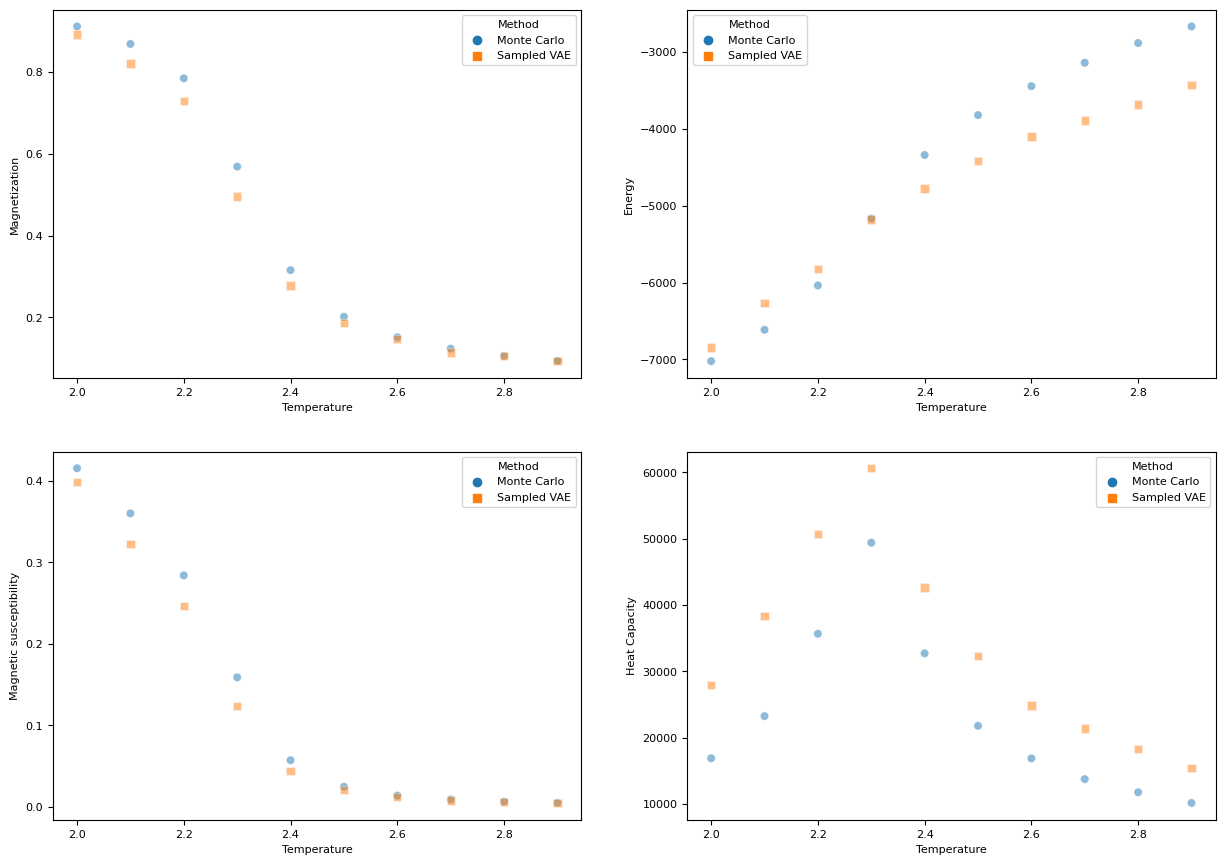

In [5]:
final_plot(data_list)
plt.savefig("final_plot.png")

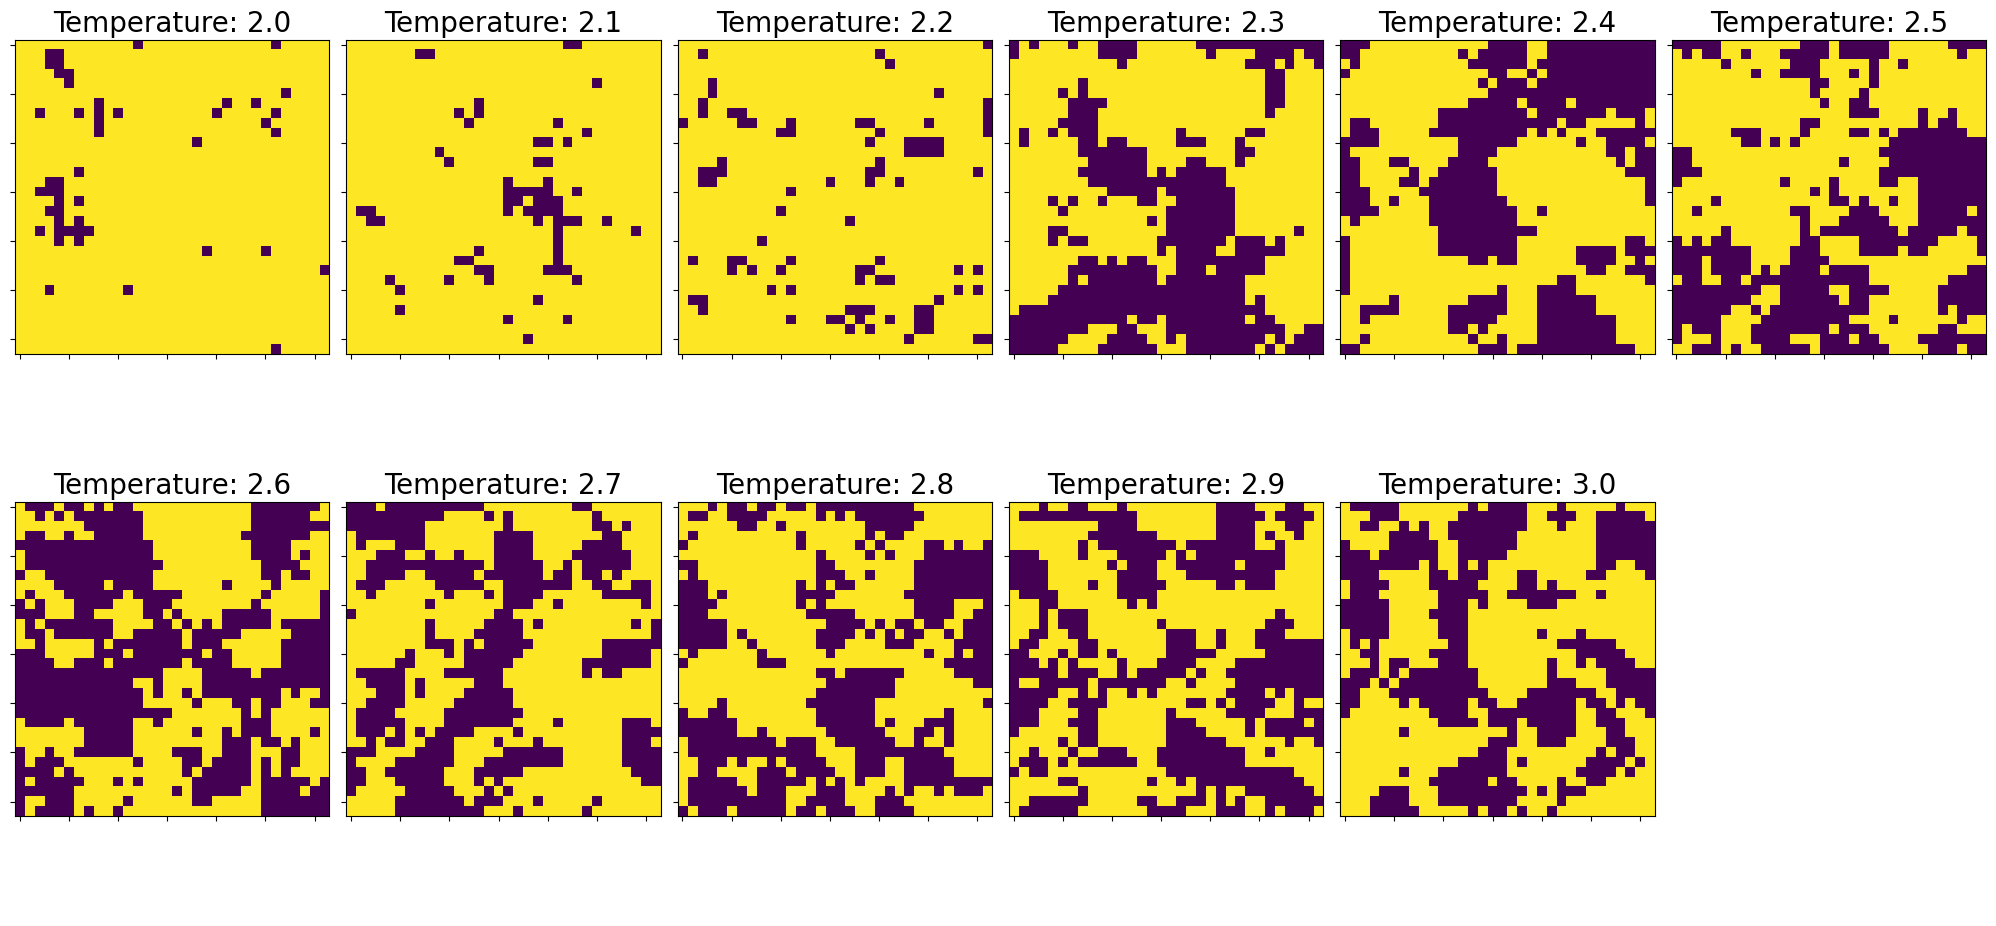

In [9]:
import math

ncols = math.ceil(len(temps) / 2)
fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(20, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(temps):
        ax.set_title(titles[i], fontsize=20)
        predictions = sample_normal(1, models[temps[i]])
        ax.yaxis.set_ticklabels([])
        ax.xaxis.set_ticklabels([])
        spins = np.random.binomial(1, predictions[0, :, :])
        ax.imshow(spins, vmin=0, vmax=1)
    else:
        ax.axis('off')

plt.subplots_adjust(hspace=0.15)
plt.tight_layout()
plt.savefig("example.svg")
plt.savefig("example.png")